In [3]:
import logging 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer

/home/ksg502/miniconda3/envs/humanity/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
logger = logging.getLogger(__name__)

In [74]:
df_uk = pd.read_csv("../data/processed/UK.csv")
df_us = pd.read_csv("../data/processed/US.csv")
df_me = pd.read_csv("../data/processed/MiddleEast.csv")

In [67]:
df_uk['region'] = 'UK'
df_us['region'] = 'US'
df_me['region'] = 'ME'

In [76]:
df_uk.source_domain.value_counts()[:10]

source_domain
www.dailymail.co.uk          298
www.theguardian.com          268
www.independent.co.uk        204
www.bbc.co.uk                122
www.britainnews.net           79
www.unitedkingdomnews.net     70
www.prnewswire.co.uk          61
www.theuknews.com             60
www.express.co.uk             55
www.mirror.co.uk              32
Name: count, dtype: int64

In [69]:
# Move BBC from ME to UK
df_uk = pd.concat([df_uk, df_me[df_me['source_domain'] == 'www.bbc.co.uk']])
df_me = df_me[df_me['source_domain'] != 'www.bbc.co.uk']
df_me = df_me[df_me['source_domain'] != 'www.aa.com.tr']

In [70]:
df_uk.source_domain.value_counts()[:3]

source_domain
www.bbc.co.uk          1096
www.dailymail.co.uk     298
www.theguardian.com     268
Name: count, dtype: int64

In [54]:
all_df = pd.concat([df_uk, df_us, df_me])

In [55]:
all_df.head()

,description,maintext,source_domain,title,url,language,date_publish,region
0,The strategy goes well beyond defeating an opp...,How to make sense of the sheer intensity of Is...,www.theguardian.com,Israel’s use of disproportionate force is a lo...,https://www.theguardian.com/commentisfree/2023...,en,2023-12-05 12:47:14,UK
1,All the conflict in Gaza is achieving is civil...,All the conflict in Gaza is achieving is civil...,www.unitedkingdomnews.net,"Israel cant defeat Hamas in battle, so what's ...",https://www.unitedkingdomnews.net/news/2740561...,en,2024-02-06 00:00:00,UK
2,"Mexico has launched its army-run airline, with...",For free real time breaking news alerts sent s...,www.independent.co.uk,"Mexico's army-run airline takes to the skies, ...",https://www.independent.co.uk/news/andres-manu...,en,2023-12-26 17:08:10,UK
3,This blog is now closed.,From 23 Dec 2023 18.49 CET UNRWA: 'People in G...,www.theguardian.com,"Death toll from Israeli attacks tops 20,000 - ...",https://www.theguardian.com/world/live/2023/de...,en,2023-12-24 00:17:56,UK
4,Palestinian Islamic Jihad posts videos of two ...,The BBC will not be broadcasting the clip itse...,www.bbc.co.uk,Israel sees 'sign of life' in Gaza hostage video,https://www.bbc.co.uk/news/world-middle-east-6...,en,2023-11-09 18:57:24,UK


In [56]:
print(f"Total: {all_df.shape}")
print(f"UK: {df_uk.shape}")
print(f"US: {df_us.shape}")
print(f"ME: {df_me.shape}")

Total: (12968, 8)
UK: (3346, 8)
US: (6936, 8)
ME: (2686, 8)


<Axes: title={'center': 'Top 40 Domains'}, xlabel='source_domain'>

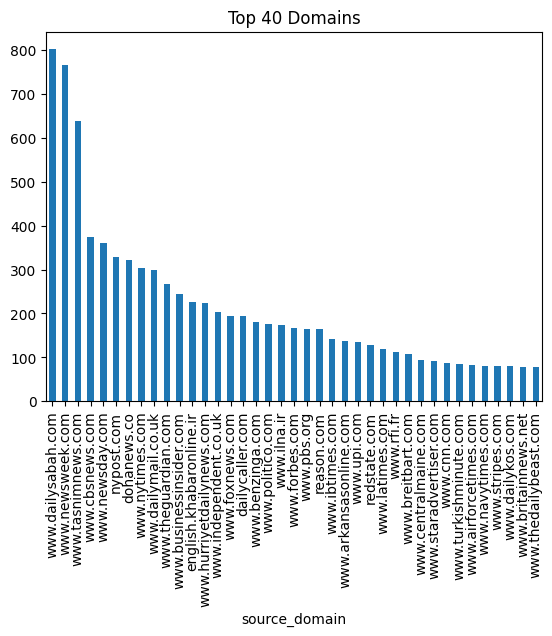

In [57]:
all_df["source_domain"].value_counts()[1:40].plot(kind='bar', title="Top 40 Domains")

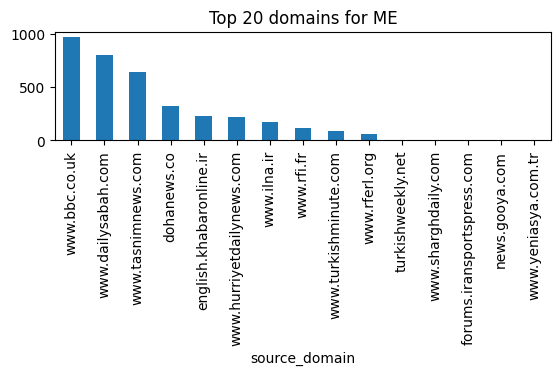

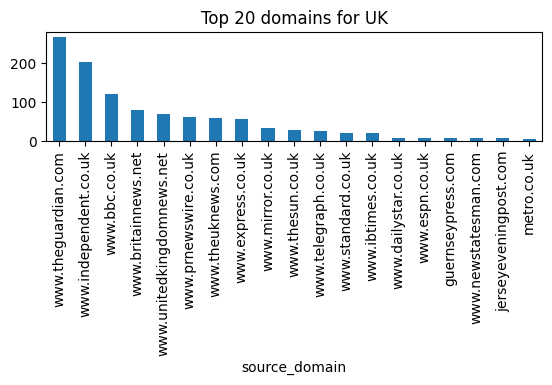

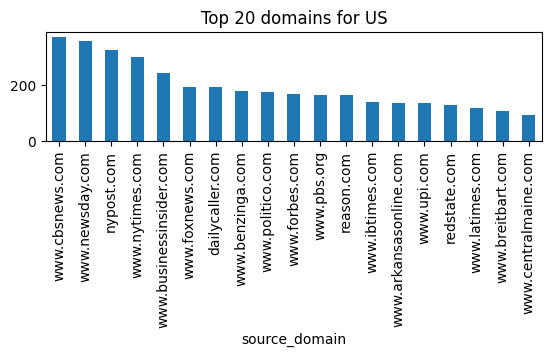

In [19]:
for g_name, group in all_df.groupby(by="region"):
    plt.subplot(3, 1, 1)
    group["source_domain"].value_counts()[1:20].plot(kind='bar', title="Top 20 domains for " + g_name)
    plt.show()

In [20]:
all_df['title_len'] = all_df['title'].apply(lambda x: len(str(x).split(" ")))
all_df['text_len'] = all_df['maintext'].apply(lambda x: len(str(x).split(" ")))

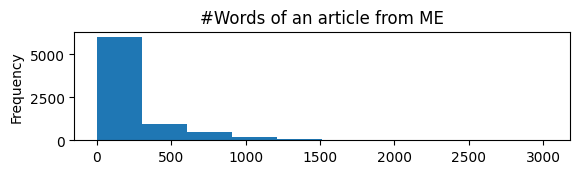

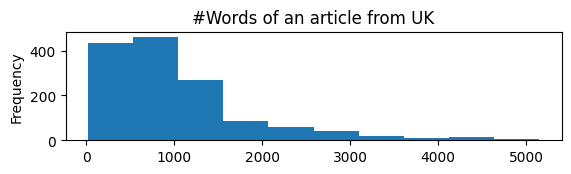

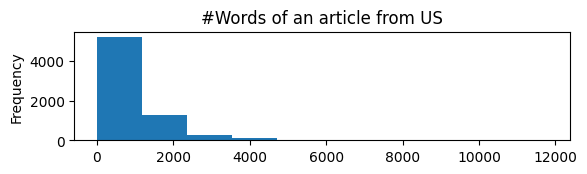

In [22]:
for g_name, group in all_df.groupby(by="region"):
    plt.subplot(3, 1, 1)
    group["text_len"].plot(kind='hist', title="#Words of an article from " + g_name)
    plt.show()

<Axes: title={'center': 'Title Length Distribution'}, ylabel='Frequency'>

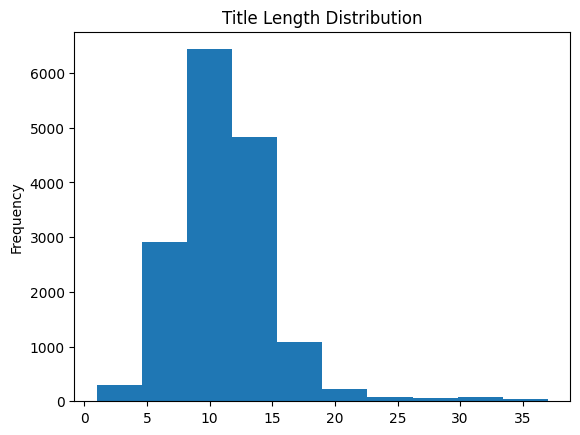

In [23]:
all_df['title_len'].plot(kind='hist', title="Title Length Distribution")

In [24]:
all_df.dropna(subset=['maintext','title'], inplace=True)

In [25]:
q_low = all_df["text_len"].quantile(0.01)
q_hi  = all_df["text_len"].quantile(0.99)

all_df = all_df[(all_df["text_len"] < q_hi) & (all_df["text_len"] > q_low)]

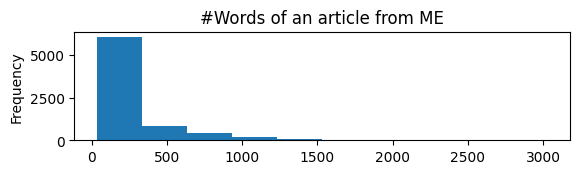

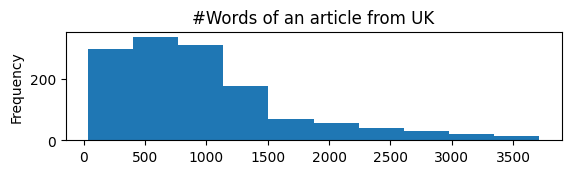

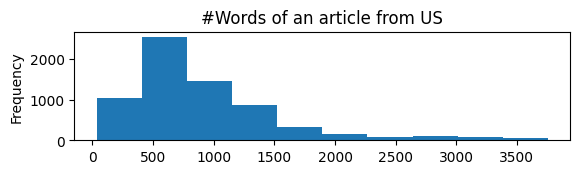

In [26]:
for g_name, group in all_df.groupby(by="region"):
    plt.subplot(3, 1, 1)
    group["text_len"].plot(kind='hist', title="#Words of an article from " + g_name)
    plt.show()

In [48]:
top_domanis = {}
for g_name, group in all_df.groupby(by="region"):
    domains = group["source_domain"].value_counts()[:4]
    if g_name == 'ME':
        domains = group["source_domain"].value_counts()[2:6]
    top_domanis[g_name] = list(domains.keys())
    print(f"Top domains for {g_name}", domains)

Top domains for ME source_domain
www.dailysabah.com         802
www.tasnimnews.com         637
dohanews.co                321
english.khabaronline.ir    225
Name: count, dtype: int64
Top domains for UK source_domain
www.dailymail.co.uk      290
www.theguardian.com      257
www.independent.co.uk    202
www.bbc.co.uk            108
Name: count, dtype: int64
Top domains for US source_domain
www.newsweek.com    765
www.cbsnews.com     370
www.newsday.com     352
nypost.com          328
Name: count, dtype: int64


In [210]:
titles = all_df.title.values
texts = all_df.maintext.values

In [211]:
tfidf = TfidfVectorizer(min_df=2, stop_words='english')
tf_idf_words = tfidf.fit_transform(all_df['title'])
tf_idf_feature_array = np.array(tfidf.get_feature_names_out())
tfidf_sorting = np.argsort(tf_idf_words.toarray()).flatten()[::-1]
n = 30
top_n = tf_idf_feature_array[tfidf_sorting][:n]
top_n

array(['morocco', 'tunisia', 'demonstrators', 'rally', 'support',
       'palestinians', 'gaza', 'evacuated', 'evaluated', 'evacuating',
       'evacuation', 'evacuate', 'eurovision', 'evacuations', 'evacuees',
       'evade', 'evacuates', 'evaluates', 'european', 'evangelical',
       'evangelicals', 'eve', 'evening', 'event', 'events', 'evidence',
       'evident', 'evil', 'evolution', 'euros'], dtype=object)

In [166]:
topic_model = BERTopic(language="english", min_topic_size=50)
topics, probs = topic_model.fit_transform(titles)

In [168]:
#topic_model.get_topic_info().to_csv("../data/outputs/topic_info_min50.csv")

In [212]:
selected_topic_df = pd.read_csv("../data/outputs/topic_info_min50.csv")
topic_mapping = selected_topic_df[['Topic','Relevant']].set_index('Topic')
selected_topics = list(topic_mapping[topic_mapping['Relevant'] == 1].index.values)

In [213]:
all_df['topic'] = topics

In [215]:
all_df = all_df[all_df['topic'].isin(selected_topics)]

In [216]:
all_df.to_csv("../data/processed/selected_data.csv", index=False)

In [219]:
topic_model = BERTopic(language="english", min_topic_size=20)
topics, probs = topic_model.fit_transform(all_df['maintext'])

In [220]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2035,-1_the_of_and_in,"[the, of, and, in, to, that, gaza, for, israel...","[DEIR AL-BALAH, Gaza Strip — Israel's governme..."
1,0,3429,0_cookies_analytics_used_is,"[cookies, analytics, used, is, alexa, cookie, ...",[Necessary Cookies\nThis cookie is used to dis...
2,1,731,1_hostages_hamas_the_of,"[hostages, hamas, the, of, in, and, released, ...",[Thirteen Israeli hostages kidnapped by Hamas ...
3,2,410,2_hospital_the_said_and,"[hospital, the, said, and, hamas, alshifa, of,...",[Two and a half weeks after sending tanks and ...
4,3,408,3_the_and_of_regime,"[the, and, of, regime, in, zionist, iran, to, ...",[Kanaani made these remarks during his weekly ...
5,4,220,4_court_genocide_south_africa,"[court, genocide, south, africa, the, case, is...","[THE HAGUE, Netherlands — Accused of committin..."
6,5,199,5_gaza_in_the_of,"[gaza, in, the, of, and, israeli, said, killed...","[By NAJIB JOBAIN, WAFAA SHURAFA and SAMY MAGDY..."
7,6,155,6_us_iraq_in_syria,"[us, iraq, in, syria, the, iraqi, attack, troo...",[WASHINGTON >> U.S. forces may have mistaken a...
8,7,123,7_protesters_police_london_the,"[protesters, police, london, the, protest, of,...",[Pro-Palestine protesters have been pictured c...
9,8,92,8_gaza_the_in_and,"[gaza, the, in, and, netanyahu, of, israel, sa...",[Israel's prime minister pushed back Saturday ...
